# This notebook goes through different EDA, data cleaning steps, and RNN models for the purpose of this Kaggle competition:
## https://www.kaggle.com/competitions/nlp-getting-started/overview


## Brief Description of the Problem and Data

The challenge involves building a model to predict which Tweets are about real disasters and which ones are not. This is a binary classification problem, where the output is 1 if the tweet is about a real disaster and 0 otherwise. For this assignment - week4 - the requirements are to use only RNN models (example LSTM) to do the text classification.

The data provided is a training set and a test set, both containing tweets with various features. The training data (`train.csv`) includes the following columns:

- `id`: a unique identifier for each tweet (this column was not used within any analysis here)
- `text`: the text of the tweet
- `location`: the location the tweet was sent from (may be blank)
- `keyword`: a particular keyword from the tweet (may be blank)
- `target`: denotes whether a tweet is about a real disaster (1) or not (0)

The training set size and structure are as follows:

- Number of entries: 7,613
- Number of features: 4 ( the id column cannot be used a feature here )

The test set (`test.csv`) has the same structure but without the `target` column. The target column is then predicted and submitted to Kaggle which is the competition part of this assignment.

## Exploratory Data Analysis (EDA)

During EDA, I found:

- The distribution of the `target` variable shows a fairly balanced dataset between disaster and non-disaster tweets.
- Common keywords and locations provided insights into frequent disaster-related terms and areas most discussed in the context of disasters.
- Text data preprocessing included removing URLs, punctuation, converting to lowercase, and removing stopwords to clean up the tweets for analysis.
- Visualizations like word clouds highlighted the most frequent words in the `keyword`, `location`, and `text` columns, confirming the relevance of certain words to disaster-related tweets.

My plan of analysis post-EDA involved preparing the text data for modeling by converting it into a numerical format that a machine learning model could understand, such as through tokenization and padding for RNN input.

## Model Architecture

For the model architecture, a Bidirectional Long Short-Term Memory (Bi-LSTM) network was chosen due to its ability to capture context from both the past and future words in a sentence, which is crucial for understanding the meaning of tweets. The architecture includes:

- An Embedding layer to convert tokenized words into dense vectors of fixed size.
- A Bi-LSTM layer to process the text data in both forward and backward directions.
- A Dense output layer with a sigmoid activation function to classify the tweets as disaster or not.

Word embeddings were utilized to improve model performance, with pre-trained GloVe vectors helping the model understand the semantic meaning of words better. In this case GloVe only slightly improved the performance which suggests something else needs to be improved here. Maybe the text cleaning or the words which are imbedding could improve performance. For further analysis you should try to embed the entire sentence using sentence to Vec or possibly GPT embeddings for greater context understanding. The assumption here is the greater the context understanding the better the prediction will be for the binary class.

Final model architecture:

## Final Model Architecture Summary
This is before the last grid search at the bottom of this notebook. The last grid search below does not significantly improve the accuracy.

- **Embedding Layer**: Utilizes pre-trained GloVe embeddings (`glove.6B.300d.txt`) with an embedding dimension of 300 and an input length of 100 tokens.
- **Bidirectional LSTM Layer**: Contains 50 units to capture both forward and backward dependencies in the text data.
- **Dense Output Layer**: A single unit with a sigmoid activation function for binary classification (disaster or not disaster tweets).
- **Compilation**: The model is compiled with the Adam optimizer and binary cross-entropy loss, measuring accuracy as the performance metric.
- **Training**: Trained on the dataset for 100 epochs, showing progressive improvement in accuracy and adjustments in loss over time. **However, this is a classic case of overfitting. The validation accuracy bounces around at 79 to 81% and goes back below 79 as the epochs go higher than 10.**
- **Performance**: Achieved a best validation accuracy of approximately 81%, demonstrating the model's capability to classify tweets into disaster and non-disaster categories effectively. As already discussed above this is only slightly better compared to the 79% accuracy achieved.


## Results and Analysis

Hyperparameter tuning and experimenting with different RNN architectures (LSTM, GRU, SimpleRNN, Bidirectional LSTM) were conducted to find the optimal setup. The best performing model was a Bidirectional LSTM with specific configurations (dropout, recurrent_dropout, optimizer, etc.).

The model achieved an accuracy of around 81% on the validation set, indicating a reasonably good performance in distinguishing between disaster and non-disaster tweets. The use of pre-trained GloVe embeddings slightly improved accuracy, suggesting the benefit of leveraging external knowledge.

## Conclusion

This week 4 mini Kaggle project showed that RNNs, specifically Bi-LSTMs with GloVe embeddings, are effective for text classification tasks like predicting disaster-related tweets. While the model performed well, further improvements could involve exploring more advanced NLP techniques, deeper architectures, or alternative word embeddings (example: BERT or GPT ADA, etc).

Future work could also include more sophisticated data preprocessing and augmentation strategies to improve model robustness and performance.

Note that in my experience using GPT word embeddings it is not necessary to remove punctuation and other stop words as this provides GPT a greater context of undertanding if left in. That is why I believe using this technique of GPT word embeddings could improve this binary classifier. GPT is able to make use of the punctuation and other parts of the text very well.


In [1]:
!pip install scikeras

import keras
print(keras.__version__)

2.15.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

!nvidia-smi

Sat Mar  2 15:38:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## check if there is a GPU available here...

In [5]:
import tensorflow as tf

# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')

# Check if any GPUs are available
if gpus:
    for gpu in gpus:
        print(f"GPU Available: {gpu}")
else:
    print("No GPU available.")


GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## when using google colab the notebook has to mount the drive before reading / writing files to it

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import pandas as pd
import re
from collections import Counter


current_working_directory = os.getcwd()
current_working_directory


'/content'

In [8]:
train_data_dir_and_file = "/content/drive/My Drive/Tweets/nlp-getting-started/train.csv"
train_data = pd.read_csv(train_data_dir_and_file)

In [9]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
from collections import Counter

# Download the NLTK stopwords...and load them.
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# process text function, remove urls, punctuation, change to lower case, remove stop words here...
def preprocess_text(text):
    # handle empty strings in data here....
    if pd.isnull(text) or text == 'nan':
        return ""

    text = re.sub(r'http\S+', '', text)  # URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # punctuation and numbers
    text = text.lower().strip()  # lower case
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words and word != 'nan')
    return text


# Preprocess text columns here on the training data to show data analysis below
text_columns = ['keyword', 'location', 'text']
text_analytics_results = []

def text_analytics(data, column):
    words = [word for line in data[column] for word in line.split()]
    word_count = len(words)
    unique_words = len(set(words))
    most_common_words = Counter(words).most_common(20)

    return {
        'column': column,
        'total_words': word_count,
        'unique_words': unique_words,
        'most_common_words': most_common_words
    }

for column in text_columns:
    # Apply the text cleaning to the training data columns here....
    train_data[column + '_cleaned'] = train_data[column].astype(str).apply(preprocess_text)

    # get basic text statistics here....
    column_analytics = text_analytics(train_data, column + '_cleaned')
    text_analytics_results.append(column_analytics)



text_analytics_results




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[{'column': 'keyword_cleaned',
  'total_words': 7552,
  'unique_words': 221,
  'most_common_words': [('fatalities', 45),
   ('armageddon', 42),
   ('deluge', 42),
   ('bodybags', 41),
   ('damage', 41),
   ('harm', 41),
   ('sinking', 41),
   ('collided', 40),
   ('evacuate', 40),
   ('fear', 40),
   ('outbreak', 40),
   ('siren', 40),
   ('twister', 40),
   ('windstorm', 40),
   ('collision', 39),
   ('derailment', 39),
   ('earthquake', 39),
   ('explosion', 39),
   ('famine', 39),
   ('flames', 39)]},
 {'column': 'location_cleaned',
  'total_words': 9389,
  'unique_words': 3012,
  'most_common_words': [('usa', 266),
   ('new', 209),
   ('ca', 148),
   ('york', 138),
   ('london', 110),
   ('uk', 98),
   ('united', 95),
   ('canada', 86),
   ('california', 83),
   ('city', 80),
   ('ny', 77),
   ('san', 71),
   ('england', 69),
   ('washington', 68),
   ('states', 64),
   ('tx', 63),
   ('australia', 62),
   ('dc', 60),
   ('los', 59),
   ('nigeria', 59)]},
 {'column': 'text_cleaned'

# Basic statistics (word count, unique words, common words) within training data:

# common words:

## 1.) set of common words (keyword column): these do appear to be key words that would be used in disaster tweets from the text analytics above (fatalities being the most frequent word makes sense as it is common within a disaster which is real)

## 2.) set of common words (location column): these do appear to be cities / areas / geographies of where the tweet was posted or where the disaster took place (new york and london / UK seem to be where most of the distasters took place or was tweeted)

## 3.)  set of common words (text column):  these do appear to be from the textual content of messages or reports, including reactions, updates, and information sharing related to emergencies and disasters

In [10]:

train_data_dir_and_file = "/content/drive/My Drive/Tweets/nlp-getting-started/train.csv"
train_data = None
train_data = pd.read_csv(train_data_dir_and_file)

# Visual of the most common words for each training dataset column using Word Clouds:
## a repeat of the above most common words using frequency counts - however it does help to visualize this to ensure the themes are the same as what was found in the above analysis

,id,keyword,location,text,target,keyword_cleaned,location_cleaned,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,,,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,,,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,,,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,,,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,,,two giant cranes holding bridge collapse nearb...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,,,ariaahrary thetawniest control wild fires cali...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,,,utckm volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,,,police investigating ebike collided car little...


0        
1        
2        
3        
4        
       ..
7608     
7609     
7610     
7611     
7612     
Name: keyword_cleaned, Length: 7613, dtype: object

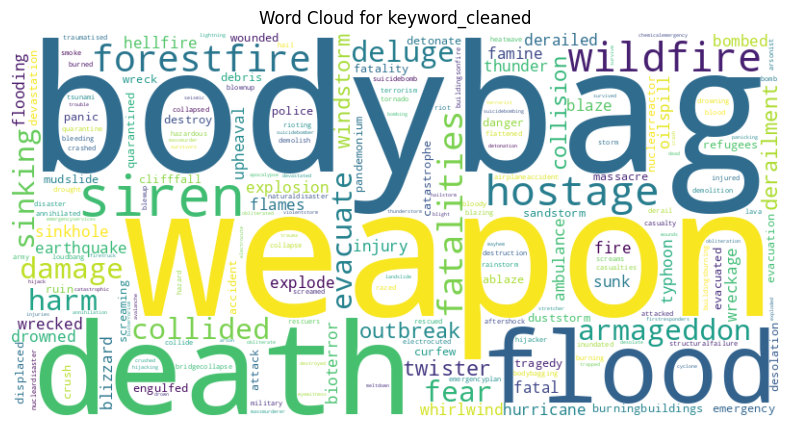

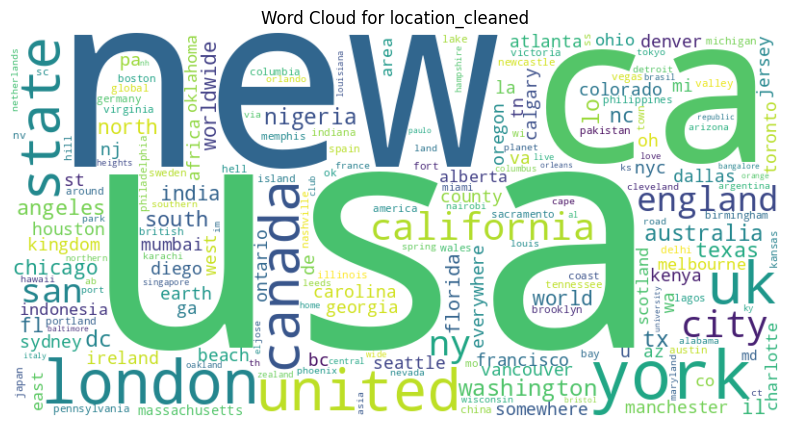

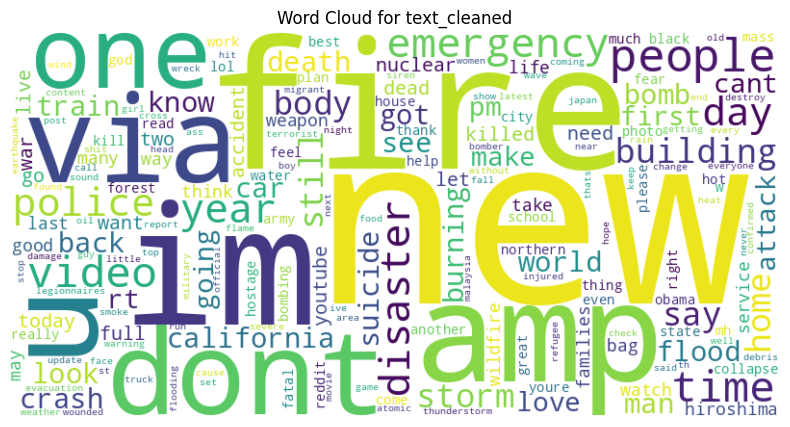

In [11]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# export the cleaned text columns for further analysis and inspection at the row level here:

# Preprocess the 'keyword', 'location', and 'text' columns
train_data['keyword_cleaned'] = train_data['keyword'].astype(str).apply(preprocess_text)
train_data['location_cleaned'] = train_data['location'].astype(str).apply(preprocess_text)
train_data['text_cleaned'] = train_data['text'].apply(preprocess_text)

# Export the DataFrame to a CSV file
output_csv_path = '/content/drive/My Drive/Tweets/nlp-getting-started/cleaned_train_data.csv'
train_data.to_csv(output_csv_path, index=False)


display(train_data)
display(train_data['keyword_cleaned'])

# Function to generate and display a word cloud for each text column
def generate_word_cloud(column_data, title):
    #print(column_data)
    wordcloud = None
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(column_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    #plt.imshow(wordcloud, interpolation='None')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word cloud for each cleaned text column
for column in ['keyword_cleaned', 'location_cleaned', 'text_cleaned']:
    text_data = ""
    text_data = " ".join(content for content in train_data[column])
    print("\n\n")
    generate_word_cloud(text_data, f'Word Cloud for {column}')


# Prepare the training and validation test sets, assume here 20% of the training data for validation on the different models:

## Note:  I tried both using the text column alone and combining the three columns into one. Both have similar performance in classification task, however the combined columns provides a slight increase in accuracy so this is the version of code shown below:

In [12]:

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, GRU, Bidirectional
from keras.callbacks import EarlyStopping
import re
import numpy as np

# Load the data

train_data = pd.read_csv(train_data_dir_and_file)

# Apply the preprocessing function to the text column
train_data['keyword'] = train_data['keyword'].apply(preprocess_text)
train_data['location'] = train_data['location'].apply(preprocess_text)
train_data['text'] = train_data['text'].apply(preprocess_text)

# Handling missing values by filling them with a placeholder
train_data['keyword'].fillna('no_keyword', inplace=True)
train_data['location'].fillna('no_location', inplace=True)

train_data['text_combined'] =  train_data['keyword'] + ' ' + train_data['location'] + ' ' + train_data['text']

#display(train_data)


X = train_data['text_combined']
y = train_data['target']

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100)  # You may want to choose a different maxlen

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.2, random_state=42)





# initially I had some issues with Tensorflow, here is some code to check if tensorflow / keras is imported properly.

In [13]:
import tensorflow as tf

# Check the TensorFlow version
print(tf.__version__)

# Test if the Sequential model can be imported
from tensorflow.keras.models import Sequential
print("Sequential model imported successfully.")



2.15.0
Sequential model imported successfully.


# Uncomment the code below to run the first grid search.
## the first goal here is to see if there is a "best" model out of these:  ['LSTM', 'GRU', 'SimpleRNN', 'Bidirectional']

## please note this took more than an hour using Google Colab on a A100 GPU

## The grid search tried several hyperparameters and came up with this one below as the best option. Based on manually trying the models as well I seem to be getting between 70 and 80% accuracy on the validation set so this does seem reasonable:

## {'batch_size': 32, 'epochs': 5, 'model__activation': 'relu', 'model__dropout': 0.2, 'model__optimizer': 'rmsprop', 'model__recurrent_dropout': 0.2, 'model__rnn_type': 'Bidirectional'}

## score on validation set:  0.798522

In [14]:
'''

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping


# Function to create the RNN model
def create_rnn_model(
    units=50,
    activation='relu',
    recurrent_activation='sigmoid',
    optimizer='adam',
    dropout=0.2,
    recurrent_dropout=0.2,
    rnn_type='LSTM',
    input_dim=None,
    output_dim=100,
    input_length=50
):
    if input_dim is None:
        raise ValueError("input_dim must be provided")

    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    if rnn_type == 'LSTM':
        model.add(LSTM(units=units, activation=activation, recurrent_activation=recurrent_activation, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif rnn_type == 'GRU':
        model.add(GRU(units=units, activation=activation, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif rnn_type == 'SimpleRNN':
        model.add(SimpleRNN(units=units, activation=activation, dropout=dropout))
    elif rnn_type == 'Bidirectional':
        model.add(Bidirectional(LSTM(units=units, activation=activation, recurrent_activation=recurrent_activation, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the model into the KerasClassifier

model = KerasClassifier(
    model=create_rnn_model,
    model__input_dim=len(tokenizer.word_index) + 1,  # Pass tokenizer word index size as input_dim
    verbose=1
)

# Define the grid search parameters

param_grid = {
    #'model__units': [50, 100],

    'model__units': [50],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__rnn_type': ['LSTM', 'GRU', 'SimpleRNN', 'Bidirectional'],
    #'batch_size': [32, 64],
    #'epochs': [10, 20],
    #'model__dropout': [0.2, 0.5],
    #'model__recurrent_dropout': [0.2, 0.5],


    'batch_size': [32],
    'epochs': [5],
    'model__dropout': [0.2],
    'model__recurrent_dropout': [0.2]
}


# Set up the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
'''

'\n\nfrom scikeras.wrappers import KerasClassifier\nfrom sklearn.model_selection import GridSearchCV\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Bidirectional, Dense\nfrom tensorflow.keras.callbacks import EarlyStopping\n\n\n# Function to create the RNN model\ndef create_rnn_model(\n    units=50,\n    activation=\'relu\',\n    recurrent_activation=\'sigmoid\',\n    optimizer=\'adam\',\n    dropout=0.2,\n    recurrent_dropout=0.2,\n    rnn_type=\'LSTM\',\n    input_dim=None,  \n    output_dim=100,  \n    input_length=50 \n):\n    if input_dim is None:\n        raise ValueError("input_dim must be provided")\n\n    model = Sequential()\n    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))\n    if rnn_type == \'LSTM\':\n        model.add(LSTM(units=units, activation=activation, recurrent_activation=recurrent_activation, dropout=dropout, recurrent_dropout=recurrent_dropout))\

# output from grid search here:

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
WARNING:tensorflow:Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
WARNING:tensorflow:Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
WARNING:tensorflow:Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
Epoch 1/5
191/191 [==============================] - 62s 285ms/step - loss: 0.6605 - accuracy: 0.6015 - val_loss: 0.5337 - val_accuracy: 0.7518
Epoch 2/5
191/191 [==============================] - 49s 257ms/step - loss: 0.4809 - accuracy: 0.7910 - val_loss: 0.4594 - val_accuracy: 0.7932
Epoch 3/5
191/191 [==============================] - 48s 250ms/step - loss: 0.3631 - accuracy: 0.8540 - val_loss: 0.4702 - val_accuracy: 0.7840
Epoch 4/5
191/191 [==============================] - 48s 250ms/step - loss: 0.3006 - accuracy: 0.8824 - val_loss: 0.4777 - val_accuracy: 0.7840
Epoch 5/5
191/191 [==============================] - 47s 248ms/step - loss: 0.2509 - accuracy: 0.9020 - val_loss: 0.5572 - val_accuracy: 0.7682
Best: 0.798522 using {'batch_size': 32, 'epochs': 5, 'model__activation': 'relu', 'model__dropout': 0.2, 'model__optimizer': 'rmsprop', 'model__recurrent_dropout': 0.2, 'model__rnn_type': 'Bidirectional',

# Run a grid search on the best model above "Bidirectional" to  improve the 79% accuracy score

# Uncomment the code below to try the grid search on different parameters within the Bidirectional RNN.

## This did not result in any improvement which suggests something else needs to be improved instead of the hyperparameters:  maybe different cleaning steps of the data or the way the text is represented (embedded vector space).


In [15]:
'''
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.optimizers import RMSprop

# Function to create the RNN model:
def create_rnn_model(
  units=50,  # Keeping the best unit size
  activation='relu',  # Keeping the best activation
  recurrent_activation='sigmoid',
  optimizer='rmsprop',  # Keeping rmsprop but will adjust its learning rate
  dropout=0.2,  # Keeping the best dropout rates
  recurrent_dropout=0.2,
  rnn_type='Bidirectional',  # Keeping the best RNN type
  input_dim=None,
  output_dim=100,  # Default value, consider tuning
  input_length=50,  # Default value, consider tuning
  learning_rate=0.001  # Default RMSprop learning rate, will be tuned
  ):
  if input_dim is None:
      raise ValueError("input_dim must be provided")

  model = Sequential()
  model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
  model.add(Bidirectional(LSTM(units=units, activation=activation, recurrent_activation=recurrent_activation, dropout=dropout, recurrent_dropout=recurrent_dropout)))
  model.add(Dense(1, activation='sigmoid'))

  # Adjusting the optimizer with the learning rate
  if optimizer == 'rmsprop':
      optimizer_instance = RMSprop(learning_rate=learning_rate)
  else:
      raise ValueError("Unsupported optimizer")

  model.compile(loss='binary_crossentropy', optimizer=optimizer_instance, metrics=['accuracy'])
  return model

# Updated parameter grid, focusing on learning rate, batch size, and epochs
param_grid = {
    'model__learning_rate': [0.001, 0.01, 0.1],  # Exploring different learning rates
    'batch_size': [16, 32, 64],  # Exploring a range of batch sizes
    'epochs': [5],  # Adjusting the number of epochs
}



# Wrap the model into the KerasClassifier
# 'model__' prefix is used for model parameters
model = KerasClassifier(
    model=create_rnn_model,
    model__input_dim=len(tokenizer.word_index) + 1,  # Pass tokenizer word index size as input_dim
    verbose=1
)



# Set up the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
'''

'\nfrom scikeras.wrappers import KerasClassifier\nfrom sklearn.model_selection import GridSearchCV\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Bidirectional, Dense\nfrom tensorflow.keras.callbacks import EarlyStopping\n\n\nfrom tensorflow.keras.optimizers import RMSprop\n\n# Function to create the RNN model:\ndef create_rnn_model(\n  units=50,  # Keeping the best unit size\n  activation=\'relu\',  # Keeping the best activation\n  recurrent_activation=\'sigmoid\',\n  optimizer=\'rmsprop\',  # Keeping rmsprop but will adjust its learning rate\n  dropout=0.2,  # Keeping the best dropout rates\n  recurrent_dropout=0.2,\n  rnn_type=\'Bidirectional\',  # Keeping the best RNN type\n  input_dim=None,\n  output_dim=100,  # Default value, consider tuning\n  input_length=50,  # Default value, consider tuning\n  learning_rate=0.001  # Default RMSprop learning rate, will be tuned\n  ):\n  if input_dim is None:\n      raise Va

In [16]:


import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Best parameters obtained from the grid search above
best_units = 50  # Keeping the best unit size
best_activation = 'relu'  # Keeping the best activation
best_recurrent_activation = 'sigmoid'
best_optimizer = 'rmsprop'  # Keeping rmsprop but will adjust its learning rate
best_dropout = 0.2  # Keeping the best dropout rates
best_recurrent_dropout = 0.2
best_rnn_type = 'Bidirectional'  # Keeping the best RNN type
best_learning_rate = 0.001  # Best learning rate
best_batch_size = 32  # Example best batch size obtained from grid search


# Function to create the RNN model, now directly using the best parameters.....
def create_rnn_model_with_best_params():
    input_dim = len(tokenizer.word_index) + 1  # Calculate input_dim based on the tokenizer's vocabulary size

    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=100, input_length=100))  # Using default values for output_dim and input_length
    if best_rnn_type == 'Bidirectional':
        model.add(Bidirectional(LSTM(units=best_units, activation=best_activation, recurrent_activation=best_recurrent_activation, dropout=best_dropout, recurrent_dropout=best_recurrent_dropout)))
    else:
        pass
    model.add(Dense(1, activation='sigmoid'))

    optimizer_instance = RMSprop(learning_rate=best_learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer_instance, metrics=['accuracy'])

    return model

# Create model using the best parameters
model = create_rnn_model_with_best_params()

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=best_batch_size,
    epochs=20,  # Running for 20 epochs
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)




Epoch 1/20
191/191 [==============================] - 112s 544ms/step - loss: 0.6744 - accuracy: 0.5903 - val_loss: 0.6150 - val_accuracy: 0.7420
Epoch 2/20
191/191 [==============================] - 97s 507ms/step - loss: 0.4807 - accuracy: 0.7962 - val_loss: 0.4548 - val_accuracy: 0.7932
Epoch 3/20
191/191 [==============================] - 94s 492ms/step - loss: 0.3734 - accuracy: 0.8519 - val_loss: 0.4602 - val_accuracy: 0.7919
Epoch 4/20
191/191 [==============================] - 94s 492ms/step - loss: 0.3056 - accuracy: 0.8795 - val_loss: 0.4939 - val_accuracy: 0.7873
Epoch 5/20
191/191 [==============================] - 93s 485ms/step - loss: 0.2622 - accuracy: 0.8975 - val_loss: 0.5025 - val_accuracy: 0.7741


## output from the above saved here from another run 6/20 steps... it stops due to early stopping:
WARNING:tensorflow:Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
WARNING:tensorflow:Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
WARNING:tensorflow:Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
Epoch 1/20
191/191 [==============================] - 63s 286ms/step - loss: 0.6734 - accuracy: 0.5803 - val_loss: 0.6248 - val_accuracy: 0.6467
Epoch 2/20
191/191 [==============================] - 47s 244ms/step - loss: 0.5865 - accuracy: 0.7691 - val_loss: 0.4576 - val_accuracy: 0.7873
Epoch 3/20
191/191 [==============================] - 47s 244ms/step - loss: 0.3717 - accuracy: 0.8440 - val_loss: 0.4558 - val_accuracy: 0.7905
Epoch 4/20
191/191 [==============================] - 47s 244ms/step - loss: 0.3147 - accuracy: 0.8772 - val_loss: 0.4659 - val_accuracy: 0.7951
Epoch 5/20
191/191 [==============================] - 46s 240ms/step - loss: 0.2618 - accuracy: 0.8974 - val_loss: 0.4945 - val_accuracy: 0.7840
Epoch 6/20
191/191 [==============================] - 46s 240ms/step - loss: 0.2174 - accuracy: 0.9159 - val_loss: 0.6201 - val_accuracy: 0.7544

In [17]:
# Evaluate the model on the test set
# X_train, X_val, y_train, y_val


test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


48/48 [==============================] - 3s 58ms/step - loss: 0.4548 - accuracy: 0.7932
Test Loss: 0.4548082947731018
Test Accuracy: 0.7931713461875916


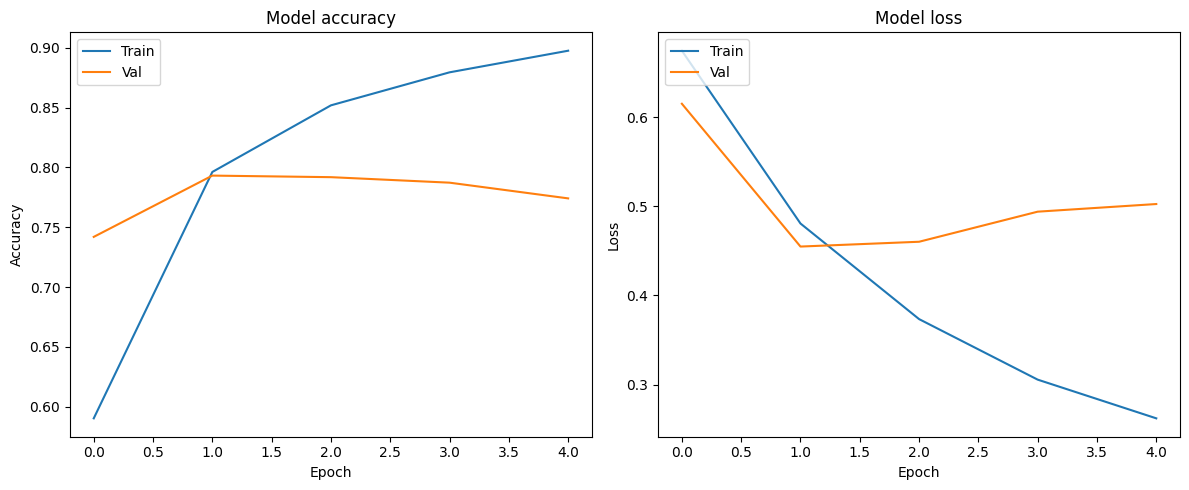

In [18]:

import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()


# Try pre-trained word embeddings here, such as Glove

## Using Glove word embeddings did result in a small increase in accuracy but from a high level did not improve signigicantly which suggests the same as already stated above. There must be something else that can be improved here. Maybe embedding the entire tweet instead of one word at a time. Also, I do believe using GPT embeddings or another sentence embedding might improve the output of the classification as the sentence or tweet has a better context compared to individual word contexts.

In [19]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
%cd /content/drive/My Drive/Tweets/nlp-getting-started/


/content/drive/My Drive/Tweets/nlp-getting-started


In [21]:
#!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#!unzip -q glove.6B.zip


In [22]:
embedding_index = {}
with open('/content/drive/My Drive/Tweets/nlp-getting-started/glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs




In [23]:
import numpy as np

embedding_dim = 300  # Update to 300d embeddings

# Correctly setting max_words to accommodate all unique words + 1 for zero padding
max_words = len(tokenizer.word_index) + 1

# Initializing the embedding matrix to zeros
embedding_matrix = np.zeros((max_words, embedding_dim))

# Populating the embedding matrix
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector




In [24]:
max_sequence_length = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [25]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))


Epoch 1/100
191/191 [==============================] - 6s 15ms/step - loss: 0.4925 - accuracy: 0.7762 - val_loss: 0.4453 - val_accuracy: 0.7978
Epoch 2/100
191/191 [==============================] - 2s 11ms/step - loss: 0.4235 - accuracy: 0.8122 - val_loss: 0.4270 - val_accuracy: 0.8129
Epoch 3/100
191/191 [==============================] - 2s 11ms/step - loss: 0.3880 - accuracy: 0.8346 - val_loss: 0.4236 - val_accuracy: 0.8188
Epoch 4/100
191/191 [==============================] - 2s 12ms/step - loss: 0.3534 - accuracy: 0.8530 - val_loss: 0.4372 - val_accuracy: 0.8030
Epoch 5/100
191/191 [==============================] - 2s 13ms/step - loss: 0.3189 - accuracy: 0.8698 - val_loss: 0.4482 - val_accuracy: 0.8056
Epoch 6/100
191/191 [==============================] - 3s 14ms/step - loss: 0.2779 - accuracy: 0.8870 - val_loss: 0.4819 - val_accuracy: 0.7965
Epoch 7/100
191/191 [==============================] - 2s 11ms/step - loss: 0.2359 - accuracy: 0.9099 - val_loss: 0.4995 - val_accuracy:

In [26]:
# Evaluate the model on the test set
# X_train, X_val, y_train, y_val
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

48/48 [==============================] - 0s 5ms/step - loss: 1.3670 - accuracy: 0.7649
Test Loss: 1.3669829368591309
Test Accuracy: 0.7649376392364502


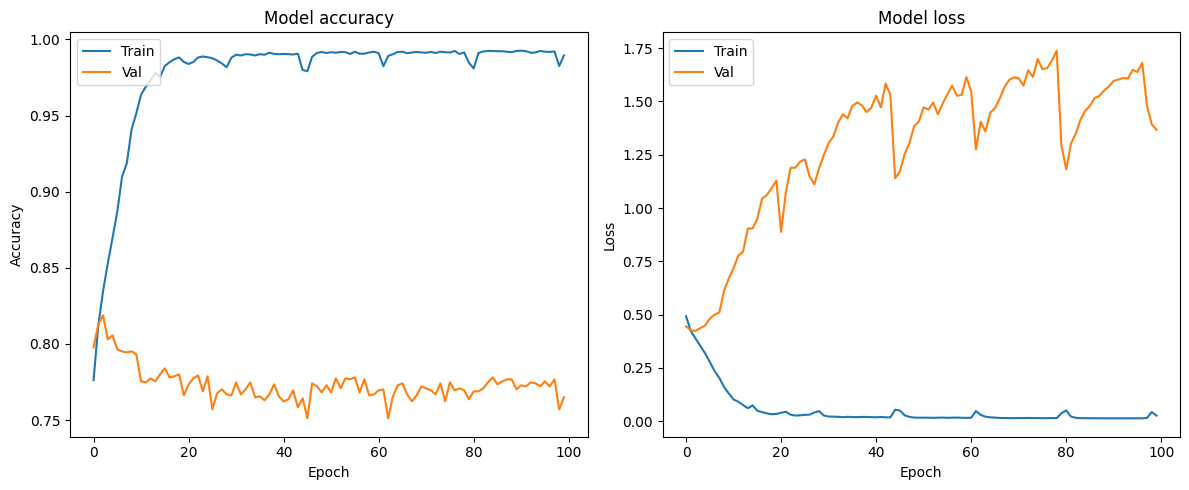

In [27]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the test data
test_df = pd.read_csv('/content/drive/My Drive/Tweets/nlp-getting-started/test.csv')


test_df['keyword'] = test_df['keyword'].apply(preprocess_text)
test_df['location'] = test_df['location'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Handling missing values by filling them with a placeholder
test_df['keyword'].fillna('no_keyword', inplace=True)
test_df['location'].fillna('no_location', inplace=True)

test_df['text_combined'] =  test_df['keyword'] + ' ' + test_df['location'] + ' ' + test_df['text']





# Convert the text to sequences
test_sequences = tokenizer.texts_to_sequences(test_df['text_combined'])

# Pad the sequences
X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Predict using the trained model
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int).reshape(-1)  

# Save the predictions to a CSV file
submission_df = pd.DataFrame({'id': test_df['id'], 'target': predictions})
submission_df.to_csv('test_results_v3.csv', index=False)


102/102 [==============================] - 1s 4ms/step


# grid search here using the 300 glove embeddings

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

def create_rnn_model(units, activation, recurrent_activation, optimizer, dropout, recurrent_dropout, rnn_type):
    input_dim = embedding_matrix.shape[0]  # Number of unique tokens in the vocabulary
    output_dim = embedding_matrix.shape[1]  # Dimensionality of GloVe embeddings
    input_length = max_sequence_length  # Length of input sequences

    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length,
                        weights=[embedding_matrix], trainable=False))  # GloVe Embedding

    if rnn_type == 'LSTM':
        model.add(LSTM(units=units, activation=activation, recurrent_activation=recurrent_activation, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif rnn_type == 'GRU':
        model.add(GRU(units=units, activation=activation, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif rnn_type == 'SimpleRNN':
        model.add(SimpleRNN(units=units, activation=activation, dropout=dropout))
    elif rnn_type == 'Bidirectional':
        model.add(Bidirectional(LSTM(units=units, activation=activation, recurrent_activation=recurrent_activation, dropout=dropout, recurrent_dropout=recurrent_dropout)))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model



In [30]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


model = KerasClassifier(model=create_rnn_model, verbose=1)

param_grid = {
    'model__units': [50],
    'model__activation': ['relu', 'tanh'],
    'model__recurrent_activation': ['sigmoid'],  # Example values
    'model__optimizer': ['adam', 'rmsprop'],
    'model__rnn_type': ['LSTM', 'GRU', 'SimpleRNN', 'Bidirectional'],
    'model__dropout': [0.2],
    'model__recurrent_dropout': [0.2],
    'batch_size': [32],
    'epochs': [4]
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



Epoch 1/4
191/191 [==============================] - 42s 201ms/step - loss: 0.5297 - accuracy: 0.7379 - val_loss: 0.4594 - val_accuracy: 0.8070
Epoch 2/4
191/191 [==============================] - 39s 203ms/step - loss: 0.4452 - accuracy: 0.8026 - val_loss: 0.4411 - val_accuracy: 0.7997
Epoch 3/4
191/191 [==============================] - 38s 198ms/step - loss: 0.4058 - accuracy: 0.8268 - val_loss: 0.4362 - val_accuracy: 0.8142
Epoch 4/4
191/191 [==============================] - 38s 199ms/step - loss: 0.3785 - accuracy: 0.8335 - val_loss: 0.4418 - val_accuracy: 0.8096
Best: 0.804598 using {'batch_size': 32, 'epochs': 4, 'model__activation': 'relu', 'model__dropout': 0.2, 'model__optimizer': 'adam', 'model__recurrent_activation': 'sigmoid', 'model__recurrent_dropout': 0.2, 'model__rnn_type': 'GRU', 'model__units': 50}
